# **1. Dự đoán hiệu suất xe hơi (regression)**

## Download dataset

In [ ]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 24.7MB/s]


## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## Read dataset

In [ ]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


## Data processing
### X,y split

In [ ]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

### Train/val/test split

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 273
Number of val samples: 79
Number of test samples: 40


### Data normalization

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Build DataLoader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

## Build MLP Network

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

In [ ]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
def r_squared(y_true, y_pred):
  y_true = torch.Tensor(y_true).to(device)
  y_pred = torch.Tensor(y_pred).to(device)
  mean_true = torch.mean(y_true)
  ss_tot = torch.sum((y_true - mean_true) ** 2)
  ss_res = torch.sum((y_true - y_pred) ** 2)
  r2 = 1 - (ss_res / ss_tot)
  return r2

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

In [ ]:
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 449.794	Validation loss: 257.050

EPOCH 2:	Training loss: 152.139	Validation loss: 154.781

EPOCH 3:	Training loss: 57.746	Validation loss: 104.600

EPOCH 4:	Training loss: 55.329	Validation loss: 69.203

EPOCH 5:	Training loss: 39.253	Validation loss: 13.744

EPOCH 6:	Training loss: 16.050	Validation loss: 5.174

EPOCH 7:	Training loss: 11.035	Validation loss: 5.600

EPOCH 8:	Training loss: 8.716	Validation loss: 12.587

EPOCH 9:	Training loss: 9.675	Validation loss: 6.191

EPOCH 10:	Training loss: 8.195	Validation loss: 8.886

EPOCH 11:	Training loss: 9.682	Validation loss: 5.685

EPOCH 12:	Training loss: 7.008	Validation loss: 6.001

EPOCH 13:	Training loss: 12.664	Validation loss: 8.673

EPOCH 14:	Training loss: 8.692	Validation loss: 12.793

EPOCH 15:	Training loss: 9.637	Validation loss: 19.321

EPOCH 16:	Training loss: 18.722	Validation loss: 6.505

EPOCH 17:	Training loss: 9.506	Validation loss: 6.992

EPOCH 18:	Training loss: 7.439	Validation loss: 10.

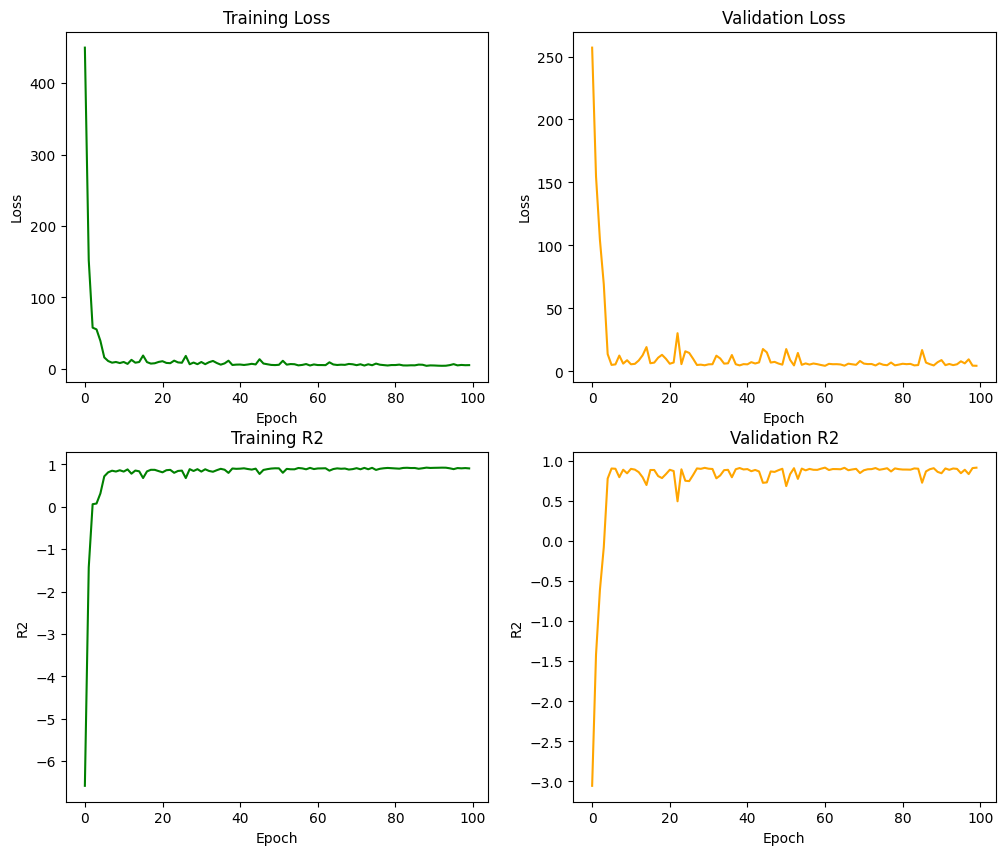

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()

## Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(X_val)
    val_set_r2 = r_squared(y_hat, y_val)
    print('Evaluation on validation set:')
    print(f'R2: {val_set_r2}')

Evaluation on validation set:
R2: 0.9090173244476318


# **2. Phân loại với dữ liệu phi tuyến (non-linear data classification)**

## Load dataset

In [ ]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 13.5MB/s]


## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## Read dataset

In [ ]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

## Data processing

### Train/val/test split

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 210
Number of val samples: 60
Number of test samples: 30


### Data normalization

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## Build DataLoader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

## Build MLP Network

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

## Training

In [ ]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  accuracy = correct / len(y_true)
  return accuracy

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [ ]:
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.927	Validation loss: 0.894

EPOCH 2:	Training loss: 0.761	Validation loss: 0.825

EPOCH 3:	Training loss: 0.704	Validation loss: 0.820

EPOCH 4:	Training loss: 0.699	Validation loss: 0.781

EPOCH 5:	Training loss: 0.673	Validation loss: 0.770

EPOCH 6:	Training loss: 0.661	Validation loss: 0.747

EPOCH 7:	Training loss: 0.630	Validation loss: 0.729

EPOCH 8:	Training loss: 0.635	Validation loss: 0.719

EPOCH 9:	Training loss: 0.621	Validation loss: 0.687

EPOCH 10:	Training loss: 0.594	Validation loss: 0.686

EPOCH 11:	Training loss: 0.585	Validation loss: 0.668

EPOCH 12:	Training loss: 0.581	Validation loss: 0.655

EPOCH 13:	Training loss: 0.557	Validation loss: 0.625

EPOCH 14:	Training loss: 0.550	Validation loss: 0.612

EPOCH 15:	Training loss: 0.536	Validation loss: 0.594

EPOCH 16:	Training loss: 0.514	Validation loss: 0.580

EPOCH 17:	Training loss: 0.525	Validation loss: 0.590

EPOCH 18:	Training loss: 0.499	Validation loss: 0.589

EPOCH 19:	Training

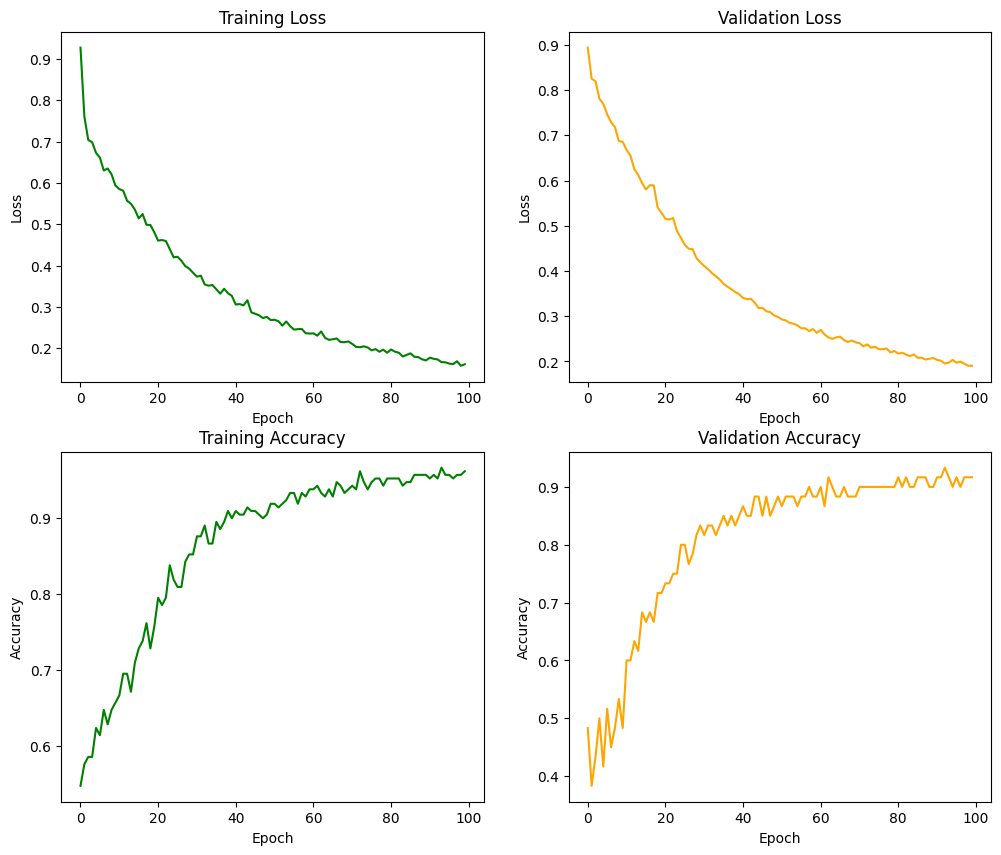

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## Evaluation

In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9333333333333333


In [ ]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.9166666666666666


# 3. Phân loại cảm xúc trên ảnh (classification)

In [ ]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=99502737-e635-43ea-be32-a57228a43558
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 208MB/s]


In [ ]:
!unzip -q './FER-2013.zip'

## Import libraries

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## Get classes

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

## Create DataLoader

In [ ]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, img_dir, norm, label2idx,
               split='train', train_ratio=0.8):
    self.resize = Resize((img_height, img_width))
    self.norm = norm
    self.split = split
    self.train_ratio = train_ratio
    self.img_dir = img_dir
    self.label2idx = label2idx
    self.img_paths, self.img_labels = self.read_img_files()

    if split in ['train', 'val'] and 'train' in img_dir.lower():
      train_data, val_data = train_test_split(
          list(zip(self.img_paths, self.img_labels)),
          train_size=self.train_ratio,
          random_state=random_state,
          stratify=self.img_labels
      )

    if split == 'train':
      self.img_paths, self.img_labels = zip(*train_data)
    elif split == 'val':
      self.img_paths, self.img_labels = zip(*val_data)

  def read_img_files(self):
    img_paths = []
    img_labels = []
    for cls in self.label2idx.keys():
      for img in os.listdir(os.path.join(self.img_dir, cls)):
        img_paths.append(os.path.join(self.img_dir, cls, img))
        img_labels.append(cls)
    return img_paths, img_labels

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    cls = self.img_labels[idx]
    img = self.resize(read_image(img_path))
    img = img.type(torch.float32)
    label = self.label2idx[cls]
    if self.norm:
      img = (img/127.5) - 1
    return img, label

In [ ]:
batch_size = 265

train_dataset = ImageDataset(train_dir, True,
                             label2idx, split='train')
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset = ImageDataset(train_dir, True,
                           label2idx, split='val')
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_dataset = ImageDataset(test_dir, True,
                            label2idx, split='test')
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

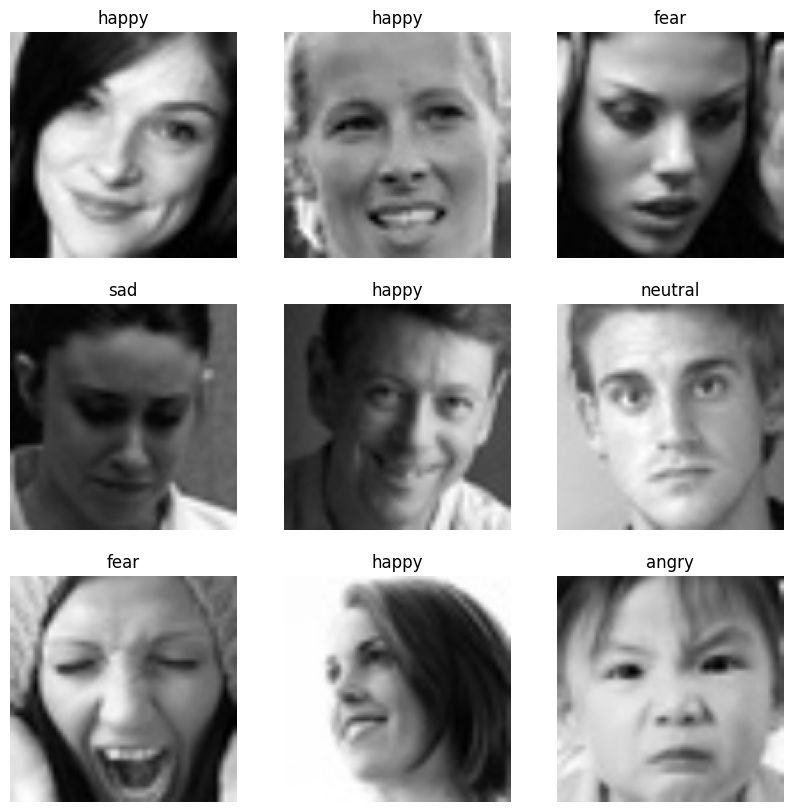

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range (9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()),
              vmin=minv,
              vmax=maxv,
              cmap="gray")
  label = label_batch[i]
  plt.title(idx2label[label.item()])
  plt.axis("off")

## Build MLP network

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims*4)
    self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
    self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [ ]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

## Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  accuracy = correct / len(y_true)
  return accuracy

In [ ]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [ ]:
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.913	Validation loss: 1.887

EPOCH 2:	Training loss: 1.861	Validation loss: 1.834

EPOCH 3:	Training loss: 1.816	Validation loss: 1.802

EPOCH 4:	Training loss: 1.792	Validation loss: 1.786

EPOCH 5:	Training loss: 1.778	Validation loss: 1.773

EPOCH 6:	Training loss: 1.764	Validation loss: 1.759

EPOCH 7:	Training loss: 1.748	Validation loss: 1.743

EPOCH 8:	Training loss: 1.730	Validation loss: 1.724

EPOCH 9:	Training loss: 1.709	Validation loss: 1.704

EPOCH 10:	Training loss: 1.689	Validation loss: 1.685

EPOCH 11:	Training loss: 1.670	Validation loss: 1.669

EPOCH 12:	Training loss: 1.655	Validation loss: 1.656

EPOCH 13:	Training loss: 1.643	Validation loss: 1.648

EPOCH 14:	Training loss: 1.632	Validation loss: 1.642

EPOCH 15:	Training loss: 1.623	Validation loss: 1.636

EPOCH 16:	Training loss: 1.615	Validation loss: 1.626

EPOCH 17:	Training loss: 1.607	Validation loss: 1.621

EPOCH 18:	Training loss: 1.600	Validation loss: 1.616

EPOCH 19:	Training

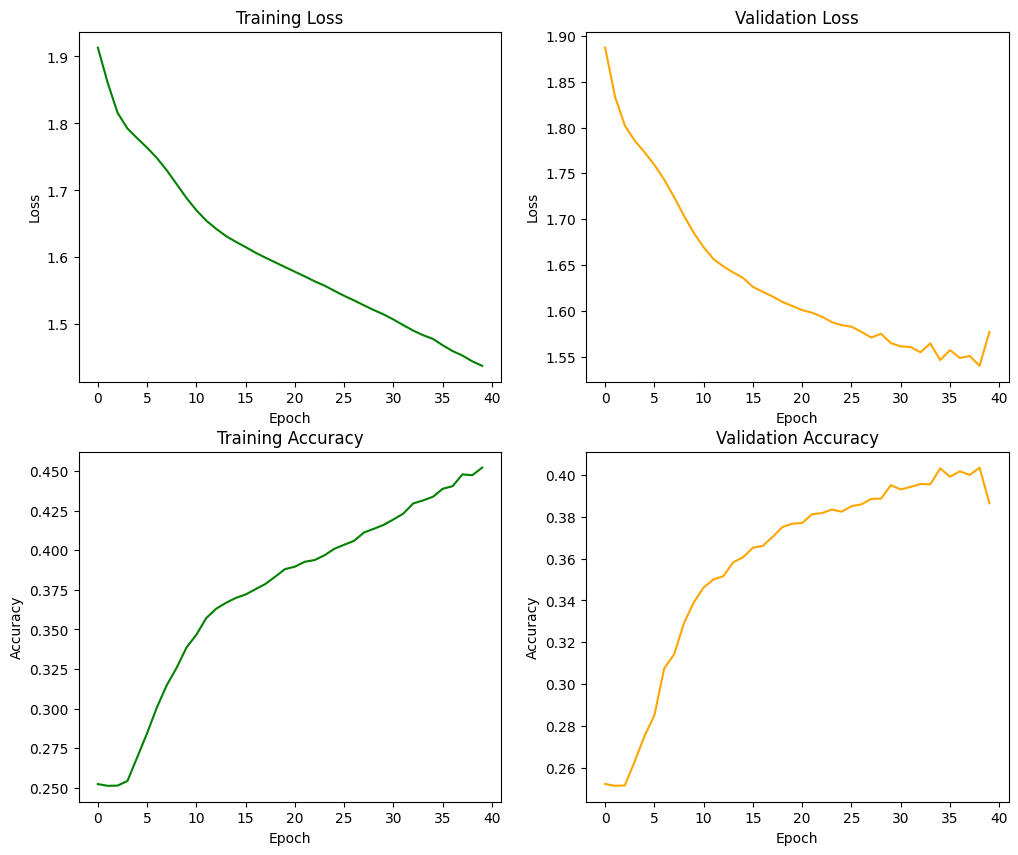

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## Evaluation

In [46]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.3966285873502368


In [47]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.38645071403692094
